In [72]:
from gensim.models import Word2Vec, callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [91]:
embed_incels = Word2Vec.load('../data/embeddings/embeddings/incels.bin')
embed_feminism = Word2Vec.load('../data/embeddings/embeddings/feminism_full.bin')
embed_braincels = Word2Vec.load('../data/embeddings/embeddings/braincels.bin')
embed_fourthwavewomen = Word2Vec.load('../data/embeddings/embeddings/fourthwavewomen.bin')
embed_mensrights = Word2Vec.load('../data/embeddings/embeddings/mensrights.bin')
embed_trufemcels = Word2Vec.load('../data/embeddings/embeddings/trufemcels.bin')
embed_feminism_2015_2017 = Word2Vec.load('../data/embeddings/embeddings/feminism_2015_2017.bin')
embed_feminism_2017_2019 = Word2Vec.load('../data/embeddings/embeddings/feminism_2017_2019.bin')
embed_feminism_2019_2021 = Word2Vec.load('../data/embeddings/embeddings/feminism_2019_2021.bin')
embed_feminism_2021_2023 = Word2Vec.load('../data/embeddings/embeddings/feminism_2021_2023.bin')
embed_incels_full = Word2Vec.load('../data/embeddings/embeddings/incels_full.bin')
embed_women = Word2Vec.load('../data/embeddings/embeddings/women.bin')
embed_blackladies = Word2Vec.load('../data/embeddings/embeddings/blackladies.bin')
embed_feminisms = Word2Vec.load('../data/embeddings/embeddings/feminisms.bin')
embed_feminismuncensored = Word2Vec.load('../data/embeddings/embeddings/feminismuncensored.bin')
embed_fireyfemmes = Word2Vec.load('../data/embeddings/embeddings/fireyfemmes.bin')


In [93]:
cleaned_incels = pd.read_pickle('../data/cleaned_corpora/clean/incels.pkl')
cleaned_feminism = pd.read_pickle('../data/cleaned_corpora/clean/feminism_full.pkl')
cleaned_braincels = pd.read_pickle('../data/cleaned_corpora/clean/braincels.pkl')
cleaned_fourthwavewomen = pd.read_pickle('../data/cleaned_corpora/clean/fourthwavewomen.pkl')
cleaned_mensrights = pd.read_pickle('../data/cleaned_corpora/clean/mensrights.pkl')
cleaned_trufemcels = pd.read_pickle('../data/cleaned_corpora/clean/trufemcels.pkl')
cleaned_feminism_2015_2017 = pd.read_pickle('../data/cleaned_corpora/clean/feminism_2015_2017.pkl')
cleaned_feminism_2017_2019 = pd.read_pickle('../data/cleaned_corpora/clean/feminism_2017_2019.pkl')
cleaned_feminism_2019_2021 = pd.read_pickle('../data/cleaned_corpora/clean/feminism_2019_2021.pkl')
cleaned_feminism_2021_2023 = pd.read_pickle('../data/cleaned_corpora/clean/feminism_2021_2023.pkl')
cleaned_incels_full = pd.read_pickle('../data/cleaned_corpora/clean/incels_full.pkl')
cleaned_women = pd.read_pickle('../data/cleaned_corpora/clean/women.pkl')
cleaned_blackladies = pd.read_pickle('../data/cleaned_corpora/clean/blackladies.pkl')
cleaned_feminisms = pd.read_pickle('../data/cleaned_corpora/clean/feminisms.pkl')
cleaned_feminismuncensored = pd.read_pickle('../data/cleaned_corpora/clean/feminismuncensored.pkl')
cleaned_fireyfemmes = pd.read_pickle('../data/cleaned_corpora/clean/fireyfemmes.pkl')

# cleaned_incels = pd.read_pickle('../data/cleaned_corpora/clean/incels.pkl')
# cleaned_feminism = pd.read_pickle('../data/cleaned_corpora/clean/feminism_full.pkl')
# cleaned_braincels = pd.read_pickle('../data/cleaned_corpora/clean/braincels.pkl')
# cleaned_fourthwavewomen = pd.read_pickle('../data/cleaned_corpora/clean/fourthwavewomen.pkl')
# cleaned_mensrights = pd.read_pickle('../data/cleaned_corpora/clean/mensrights.pkl')
# cleaned_trufemcels = pd.read_pickle('../data/cleaned_corpora/clean/trufemcels.pkl')

In [96]:
embed_incels.wv.most_similar("woman", negative="man", topn=5)

[('foids', 0.4865388870239258),
 ('femoids', 0.46247217059135437),
 ('female', 0.46043917536735535),
 ('females', 0.40718817710876465),
 ('mostly', 0.3537827432155609)]

In [3]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)
    # re-filling the normed vectors
    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()  
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

In [94]:
counts = {'feminism':Counter([x for xs in cleaned_feminism['body_clean'].tolist() for x in xs]),
          'incels':Counter([x for xs in cleaned_incels['body_clean'].tolist() for x in xs]),
          'braincels':Counter([x for xs in cleaned_braincels['body_clean'].tolist() for x in xs]),
          'fourthwavewomen':Counter([x for xs in cleaned_fourthwavewomen['body_clean'].tolist() for x in xs]),
          'mensrights':Counter([x for xs in cleaned_mensrights['body_clean'].tolist() for x in xs]),
          'trufemcels':Counter([x for xs in cleaned_trufemcels['body_clean'].tolist() for x in xs]),
         'feminism_2015_2017':Counter([x for xs in cleaned_feminism_2015_2017['body_clean'].tolist() for x in xs]),
         'feminism_2017_2019':Counter([x for xs in cleaned_feminism_2017_2019['body_clean'].tolist() for x in xs]),
         'feminism_2019_2021':Counter([x for xs in cleaned_feminism_2019_2021['body_clean'].tolist() for x in xs]),
         'feminism_2021_2023':Counter([x for xs in cleaned_feminism_2021_2023['body_clean'].tolist() for x in xs]),
         'incels_full':Counter([x for xs in cleaned_incels_full['body_clean'].tolist() for x in xs]),
         'women':Counter([x for xs in cleaned_women['body_clean'].tolist() for x in xs]),
         'blackladies':Counter([x for xs in cleaned_blackladies['body_clean'].tolist() for x in xs]),
         'feminisms':Counter([x for xs in cleaned_feminisms['body_clean'].tolist() for x in xs]),
         'feminismuncensored':Counter([x for xs in cleaned_feminismuncensored['body_clean'].tolist() for x in xs]),
         'fireyfemmes':Counter([x for xs in cleaned_fireyfemmes['body_clean'].tolist() for x in xs])}

In [95]:
probs = {}
for sub in counts:
    probs[sub] = {}
    total_words = float(sum(list(counts[sub].values())))
    for word in counts[sub]:
        probs[sub][word] = float(counts[sub][word])/total_words

In [97]:
aligned = {'feminism':embed_feminism,
          'incels':smart_procrustes_align_gensim(embed_feminism, embed_incels, words=None),
          'braincels':smart_procrustes_align_gensim(embed_feminism, embed_braincels, words=None),
          'fourthwavewomen':smart_procrustes_align_gensim(embed_feminism, embed_fourthwavewomen, words=None),
          'mensrights':smart_procrustes_align_gensim(embed_feminism, embed_mensrights, words=None),
          'trufemcels':smart_procrustes_align_gensim(embed_feminism, embed_trufemcels, words=None),
          'feminism_2015_2017':smart_procrustes_align_gensim(embed_feminism, embed_feminism_2015_2017, words=None),
          'feminism_2017_2019':smart_procrustes_align_gensim(embed_feminism, embed_feminism_2017_2019, words=None),
          'feminism_2019_2021':smart_procrustes_align_gensim(embed_feminism, embed_feminism_2019_2021, words=None),
          'feminism_2021_2023':smart_procrustes_align_gensim(embed_feminism, embed_feminism_2021_2023, words=None),
          'incels_full':smart_procrustes_align_gensim(embed_feminism, embed_incels_full, words=None),
          'women':smart_procrustes_align_gensim(embed_feminism, embed_women, words=None),
          'blackladies':smart_procrustes_align_gensim(embed_feminism, embed_blackladies, words=None),
          'feminisms':smart_procrustes_align_gensim(embed_feminism, embed_feminisms, words=None),
          'feminismuncensored':smart_procrustes_align_gensim(embed_feminism, embed_feminismuncensored, words=None),
          'fireyfemmes':smart_procrustes_align_gensim(embed_feminism, embed_fireyfemmes, words=None)}

20547 20547
20547 20547
20352 20352
20352 20352
12162 12162
12162 12162
12116 12116
12116 12116
9264 9264
9264 9264
7156 7156
7156 7156
7073 7073
7073 7073
7034 7034
7034 7034
6990 6990
6990 6990
6990 6990
6990 6990
6877 6877
6877 6877
6856 6856
6856 6856
2947 2947
2947 2947
2943 2943
2943 2943
2760 2760
2760 2760


In [113]:
aligned['fourthwavewomen'].wv.most_similar("drag", topn=10)

[('exaggerated', 0.32004570960998535),
 ('blackface', 0.3131670653820038),
 ('womanhood', 0.28360310196876526),
 ('art', 0.28339090943336487),
 ('mockery', 0.27614331245422363),
 ('contestant', 0.2655812203884125),
 ('turn', 0.25630345940589905),
 ('bending', 0.2553028166294098),
 ('mud', 0.25179868936538696),
 ('comedy', 0.24483081698417664)]

In [114]:
aligned['feminism'].wv.most_similar("drag", topn=10)

[('turn', 0.4088318645954132),
 ('walk', 0.36074382066726685),
 ('put', 0.35657799243927),
 ('run', 0.33234041929244995),
 ('throw', 0.3307940363883972),
 ('kick', 0.31858760118484497),
 ('go', 0.3178764283657074),
 ('pull', 0.3131450414657593),
 ('pass', 0.3040296733379364),
 ('come', 0.30123740434646606)]

In [121]:
aligned['incels'].wv.most_similar("normie", topn=10)

[('norman', 0.758135974407196),
 ('normies', 0.5811753273010254),
 ('incel', 0.5172886252403259),
 ('redditor', 0.43678387999534607),
 ('troll', 0.4222727119922638),
 ('cuck', 0.4061678946018219),
 ('fag', 0.4058626890182495),
 ('retard', 0.4058583378791809),
 ('faggot', 0.4037526249885559),
 ('moron', 0.37489235401153564)]

In [123]:
aligned['fourthwavewomen'].wv.most_similar("queer", topn=10)

[('lesbian', 0.3623635470867157),
 ('lgbtq', 0.3587566912174225),
 ('lgbt', 0.35160940885543823),
 ('trans', 0.3414246737957001),
 ('gay', 0.33146288990974426),
 ('butch', 0.30254098773002625),
 ('bisexual', 0.301673948764801),
 ('ci', 0.2992120385169983),
 ('oregon', 0.2720903754234314),
 ('homosexual', 0.2690664827823639)]

In [124]:
aligned['feminism'].wv.most_similar("queer", topn=10)

[('lgbtq', 0.5339240431785583),
 ('lesbian', 0.5282939076423645),
 ('trans', 0.5206756591796875),
 ('lgbt', 0.4827718734741211),
 ('gay', 0.47943782806396484),
 ('bi', 0.4320821762084961),
 ('ci', 0.4033234715461731),
 ('feminist', 0.37229588627815247),
 ('poc', 0.37227535247802734),
 ('black', 0.3590339422225952)]

In [125]:
aligned['incels'].wv.most_similar("queer", topn=10)

[('faggot', 0.3306269645690918),
 ('fag', 0.287496954202652),
 ('commie', 0.28183820843696594),
 ('here', 0.2753140926361084),
 ('gay', 0.2690238952636719),
 ('genderqueer', 0.2659413814544678),
 ('cucks', 0.26141899824142456),
 ('forum', 0.2586354911327362),
 ('dyke', 0.25566914677619934),
 ('poser', 0.2492012083530426)]

In [126]:
aligned['braincels'].wv.most_similar("queer", topn=10)

[('dyke', 0.46479251980781555),
 ('genderfluid', 0.4502195119857788),
 ('tranny', 0.420787513256073),
 ('homophobic', 0.3962024450302124),
 ('trans', 0.39547979831695557),
 ('lesbian', 0.3898167610168457),
 ('homophobe', 0.37469685077667236),
 ('pansexual', 0.37375256419181824),
 ('gay', 0.3699360489845276),
 ('bisexual', 0.3664504587650299)]

In [128]:
aligned['incels_full'].wv.most_similar("queer", topn=10)

[('lgbt', 0.6260424256324768),
 ('lgbtq', 0.619588315486908),
 ('trans', 0.5710551738739014),
 ('gay', 0.5156146287918091),
 ('transgender', 0.49387627840042114),
 ('cis', 0.4715322256088257),
 ('bisexual', 0.467258483171463),
 ('terf', 0.45662206411361694),
 ('bi', 0.45638835430145264),
 ('homophobic', 0.45002254843711853)]

In [98]:
similarity_matrices = {}
for sub in aligned:

    similarity_matrices[sub] = np.dot(aligned[sub].wv.vectors, aligned[sub].wv.vectors.T)

In [99]:
def computeEmbeddingsDist(sub1,sub2,similarity_matrices,weighted=False,freq=None):
    mat1 = similarity_matrices[sub1]
    mat2 = similarity_matrices[sub2]

    vocab1 = aligned[sub1].wv.index_to_key
    vocab2 = aligned[sub2].wv.index_to_key

    df1 = pd.DataFrame(mat1,index=vocab1,columns=vocab1)
    df2 = pd.DataFrame(mat2,index=vocab2,columns=vocab2)

    shared_vocab = [w for w in vocab1 if w in vocab2]

    df1 = df1[shared_vocab].loc[shared_vocab]
    df2 = df2[shared_vocab].loc[shared_vocab]

    mat1 = df1.to_numpy()
    mat2 = df2.to_numpy()

    all_difs = np.abs(mat1-mat2)
    
    if weighted==True:
        freq1 = freq[sub1]
        freq2 = freq[sub2]
        weights = np.zeros([len(shared_vocab),len(shared_vocab)])
        for i in range(len(shared_vocab)):
            for j in range(len(shared_vocab)):
                weights[i,j] = np.mean(freq1[shared_vocab[i]]+freq2[shared_vocab[i]]+freq1[shared_vocab[j]]+freq2[shared_vocab[j]])
#         weights = [np.mean(freq1[w1]+freq2[w1]+freq1[w2]+freq2[w2])]
    
        weighted_difs = np.multiply(weights,all_difs)
    avg_dif = np.sum(all_difs)/(len(shared_vocab)**2)
    
    return(avg_dif)
    
    
    
    

In [108]:
diffdf = pd.DataFrame(index=aligned.keys(),columns=aligned.keys(),dtype=float)
for sub1 in aligned.keys():
    for sub2 in aligned.keys():
        if sub1 != sub2:
            print(sub1+' vs '+sub2)

            diffdf.loc[sub1, sub2] = computeEmbeddingsDist(sub1,sub2,similarity_matrices)
        else:
            diffdf.loc[sub1, sub2] = 0.0

feminism vs incels
feminism vs braincels
feminism vs fourthwavewomen
feminism vs mensrights
feminism vs trufemcels
feminism vs feminism_2015_2017
feminism vs feminism_2017_2019
feminism vs feminism_2019_2021
feminism vs feminism_2021_2023
feminism vs incels_full
feminism vs women
feminism vs blackladies
feminism vs feminisms
feminism vs feminismuncensored
feminism vs fireyfemmes
incels vs feminism
incels vs braincels
incels vs fourthwavewomen
incels vs mensrights
incels vs trufemcels
incels vs feminism_2015_2017
incels vs feminism_2017_2019
incels vs feminism_2019_2021
incels vs feminism_2021_2023
incels vs incels_full
incels vs women
incels vs blackladies
incels vs feminisms
incels vs feminismuncensored
incels vs fireyfemmes
braincels vs feminism
braincels vs incels
braincels vs fourthwavewomen
braincels vs mensrights
braincels vs trufemcels
braincels vs feminism_2015_2017
braincels vs feminism_2017_2019
braincels vs feminism_2019_2021
braincels vs feminism_2021_2023
braincels vs ince

In [101]:
diffdf

,feminism,incels,braincels,fourthwavewomen,mensrights,trufemcels,feminism_2015_2017,feminism_2017_2019,feminism_2019_2021,feminism_2021_2023,incels_full,women,blackladies,feminisms,feminismuncensored,fireyfemmes
feminism,0.000000,52.483125,59.594211,49.334173,49.082533,54.337311,49.374371,40.543587,38.174131,39.929813,69.184734,50.627188,49.013976,58.005751,51.211905,58.604432
incels,52.483159,0.000000,39.859737,41.854147,53.150319,46.794828,52.855609,52.822461,53.002243,53.210743,53.895958,52.225806,52.993403,63.592388,60.678077,63.350834
braincels,59.594224,39.859818,0.000000,53.483503,54.975742,57.264237,63.720421,62.002821,61.693694,62.102067,40.814477,61.340833,59.485399,79.759114,71.949250,77.620542
fourthwavewomen,49.334182,41.854122,53.483368,0.000000,53.327681,31.226106,34.224680,38.453263,39.383093,38.773539,73.061837,40.126533,46.396714,43.398651,50.565928,48.826289
mensrights,49.082554,53.150218,54.975582,53.327778,0.000000,57.739638,62.214396,59.706333,59.151822,60.054622,47.098386,61.228036,60.203151,76.772220,62.920174,74.648931
trufemcels,54.337337,46.794894,57.264243,31.226160,57.739751,0.000000,32.663504,38.301139,39.702240,39.042962,73.287143,38.241691,45.094543,39.428740,52.477948,46.207473
feminism_2015_2017,49.374388,52.855604,63.720366,34.224655,62.214361,32.663552,0.000000,35.257468,37.027492,36.818158,76.265089,38.651883,46.465113,37.217692,49.441933,46.261483
feminism_2017_2019,40.543604,52.822441,62.002841,38.453220,59.706343,38.301198,35.257406,0.000000,39.418301,39.620341,72.678628,41.856211,47.553919,45.002628,48.689451,50.121651
feminism_2019_2021,38.174127,53.002010,61.693694,39.382995,59.151884,39.702180,37.027481,39.418306,0.000000,39.988627,71.794037,42.518787,47.824097,46.715497,49.365374,51.143688
feminism_2021_2023,39.929838,53.210775,62.101989,38.773447,60.054658,39.043006,36.818121,39.620320,39.988695,0.000000,72.488216,41.559427,47.247272,46.002985,50.550304,50.272514


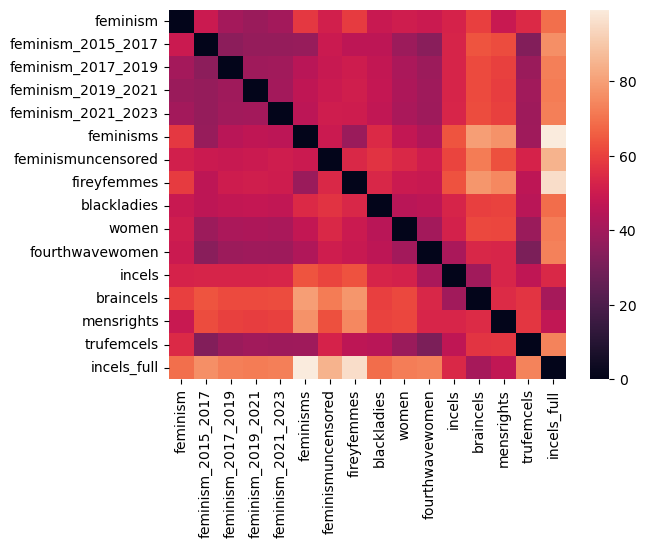

In [109]:
colOrder = ['feminism',
'feminism_2015_2017',
'feminism_2017_2019',
'feminism_2019_2021',
'feminism_2021_2023',
'feminisms',
'feminismuncensored',
'fireyfemmes',
'blackladies',
'women',
'fourthwavewomen',
'incels',
'braincels',
'mensrights',
'trufemcels',
'incels_full']

fig,ax = plt.subplots()
sns.heatmap(diffdf[colOrder].loc[colOrder],cmap=None,ax=ax)
fig.patch.set_alpha(0)
plt.savefig('../figs/dist_heatmap.png',bbox_inches='tight',dpi=600)

In [107]:
weighted_diffdf = pd.DataFrame(index=aligned.keys(),columns=aligned.keys(),dtype=float)
for sub1 in aligned.keys():
    for sub2 in aligned.keys():
        if sub1 != sub2:
            print(sub1+' vs '+sub2)

            weighted_diffdf.loc[sub1, sub2] = computeEmbeddingsDist(sub1,sub2,similarity_matrices,True,probs)
        else:
            weighted_diffdf.loc[sub1, sub2] = 0.0

feminism vs incels


KeyboardInterrupt: 

In [105]:
weighted_diffdf = diffdf.copy()

In [106]:
weighted_diffdf

,feminism,incels,braincels,fourthwavewomen,mensrights,trufemcels,feminism_2015_2017,feminism_2017_2019,feminism_2019_2021,feminism_2021_2023,incels_full,women,blackladies,feminisms,feminismuncensored,fireyfemmes
feminism,0.000000,52.483125,59.594211,49.334173,49.082533,54.337311,49.374371,40.543587,38.174131,39.929813,69.184734,50.627188,49.013976,58.005751,51.211905,58.604432
incels,52.483159,0.000000,39.859737,41.854147,53.150319,46.794828,52.855609,52.822461,53.002243,53.210743,53.895958,52.225806,52.993403,63.592388,60.678077,63.350834
braincels,59.594224,39.859818,0.000000,53.483503,54.975742,57.264237,63.720421,62.002821,61.693694,62.102067,40.814477,61.340833,59.485399,79.759114,71.949250,77.620542
fourthwavewomen,49.334182,41.854122,53.483368,0.000000,53.327681,31.226106,34.224680,38.453263,39.383093,38.773539,73.061837,40.126533,46.396714,43.398651,50.565928,48.826289
mensrights,49.082554,53.150218,54.975582,53.327778,0.000000,57.739638,62.214396,59.706333,59.151822,60.054622,47.098386,61.228036,60.203151,76.772220,62.920174,74.648931
trufemcels,54.337337,46.794894,57.264243,31.226160,57.739751,0.000000,32.663504,38.301139,39.702240,39.042962,73.287143,38.241691,45.094543,39.428740,52.477948,46.207473
feminism_2015_2017,49.374388,52.855604,63.720366,34.224655,62.214361,32.663552,0.000000,35.257468,37.027492,36.818158,76.265089,38.651883,46.465113,37.217692,49.441933,46.261483
feminism_2017_2019,40.543604,52.822441,62.002841,38.453220,59.706343,38.301198,35.257406,0.000000,39.418301,39.620341,72.678628,41.856211,47.553919,45.002628,48.689451,50.121651
feminism_2019_2021,38.174127,53.002010,61.693694,39.382995,59.151884,39.702180,37.027481,39.418306,0.000000,39.988627,71.794037,42.518787,47.824097,46.715497,49.365374,51.143688
feminism_2021_2023,39.929838,53.210775,62.101989,38.773447,60.054658,39.043006,36.818121,39.620320,39.988695,0.000000,72.488216,41.559427,47.247272,46.002985,50.550304,50.272514


In [ ]:
fig,ax = plt.subplots()
sns.heatmap(weighted_diffdf,cmap=None,ax=ax)
fig.patch.set_alpha(0)
# plt.savefig('../figs/weighted_dist_heatmap.png',bbox_inches='tight',dpi=600)

In [100]:
embed_fourthwavewomen_aligned.wv.most_similar("woman", negative="man", topn=10)

[('u', 0.42690005898475647),
 ('people', 0.3604770600795746),
 ('libfems', 0.35098347067832947),
 ('men', 0.3495567739009857),
 ('themselves', 0.3473474383354187),
 ('their', 0.3050008714199066),
 ('often', 0.30399733781814575),
 ('female', 0.27815136313438416),
 ('minority', 0.26378491520881653),
 ('our', 0.2584479749202728)]

In [101]:
embed_incels_aligned.wv.most_similar("woman", negative="man", topn=10)

[('femoids', 0.46247217059135437),
 ('female', 0.46043911576271057),
 ('females', 0.40718817710876465),
 ('mostly', 0.3537827730178833),
 ('tend', 0.3437085747718811),
 ('selective', 0.33917903900146484),
 ('they', 0.32807475328445435),
 ('them', 0.3220688998699188),
 ('womens', 0.3217262625694275),
 ('primarily', 0.3105664551258087)]

In [102]:
embed_mensrights_aligned.wv.most_similar("woman", negative="man", topn=10)

[('men', 0.4077305793762207),
 ('female', 0.3886113464832306),
 ('historically', 0.37396132946014404),
 ('womens', 0.36237233877182007),
 ('feminists', 0.33796218037605286),
 ('mostly', 0.32462799549102783),
 ('worldwide', 0.31802821159362793),
 ('largely', 0.31137311458587646),
 ('stem', 0.3092786371707916),
 ('feminist', 0.3000350594520569)]

In [103]:
embed_feminism.wv.most_similar("woman", negative="man", topn=10)

[('people', 0.3390054404735565),
 ('womens', 0.3257337510585785),
 ('worldwide', 0.3048141598701477),
 ('female', 0.29843610525131226),
 ('minority', 0.28961700201034546),
 ('themselves', 0.28780806064605713),
 ('men', 0.28292807936668396),
 ('primarily', 0.2823163568973541),
 ('discrimination', 0.2798822820186615),
 ('western', 0.2796836793422699)]

In [104]:
embed_fourthwavewomen_aligned.wv.most_similar("trans", topn=10)

[('cis', 0.46085023880004883),
 ('nb', 0.4535815417766571),
 ('transmen', 0.4420397877693176),
 ('transgender', 0.4084013104438782),
 ('transwomen', 0.4029647409915924),
 ('transphobic', 0.3912295401096344),
 ('afab', 0.3889358341693878),
 ('genderqueer', 0.38403841853141785),
 ('ftm', 0.3689112961292267),
 ('inclusive', 0.3408755958080292)]

In [105]:
embed_feminism.wv.most_similar("trans", topn=10)

[('transgender', 0.7600896954536438),
 ('cis', 0.6563048958778381),
 ('intersex', 0.6009594202041626),
 ('nonbinary', 0.5756872296333313),
 ('queer', 0.546472430229187),
 ('transwomen', 0.5276252627372742),
 ('ci', 0.5117029547691345),
 ('nb', 0.5075865387916565),
 ('transphobic', 0.46477505564689636),
 ('afab', 0.46441978216171265)]

In [90]:
embed_incels_aligned.wv.most_similar("trans", topn=10)

[('transgender', 0.872365415096283),
 ('ftm', 0.6808600425720215),
 ('transgendered', 0.6708664298057556),
 ('mtf', 0.6565186977386475),
 ('transwomen', 0.6514958143234253),
 ('transsexual', 0.6390201449394226),
 ('transmen', 0.6373894810676575),
 ('transexual', 0.6355262398719788),
 ('cis', 0.6304329037666321),
 ('transgenders', 0.6283801794052124)]

In [107]:
embed_feminism.wv.most_similar("drag", topn=10)

[('turn', 0.4038698375225067),
 ('put', 0.38228845596313477),
 ('walk', 0.37536656856536865),
 ('pull', 0.3608649671077728),
 ('throw', 0.3574683368206024),
 ('go', 0.3367087244987488),
 ('pass', 0.3288944959640503),
 ('run', 0.32530999183654785),
 ('kick', 0.3195609748363495),
 ('parade', 0.3162284195423126)]

In [108]:
embed_fourthwavewomen.wv.most_similar("drag", topn=10)

[('minstrel', 0.37470847368240356),
 ('rupaul', 0.35755622386932373),
 ('art', 0.29489752650260925),
 ('exaggerated', 0.28913986682891846),
 ('contestant', 0.2777424454689026),
 ('womanhood', 0.2734593152999878),
 ('blackface', 0.26875466108322144),
 ('bending', 0.26395267248153687),
 ('comedic', 0.26365116238594055),
 ('femininity', 0.26066672801971436)]

In [119]:
embed_incels_aligned.wv.most_similar("drag", topn=10)

[('turn', 0.5794810652732849),
 ('put', 0.5323150753974915),
 ('kick', 0.5293588638305664),
 ('run', 0.5213775038719177),
 ('knock', 0.502566933631897),
 ('push', 0.4978696405887604),
 ('crawl', 0.4778675138950348),
 ('lock', 0.47710537910461426),
 ('sneak', 0.4756006896495819),
 ('throw', 0.47021883726119995)]

#### extra filtering step

In [12]:
aligned['incels'].wv.index_to_key

['be',
 'the',
 'to',
 'and',
 'you',
 'it',
 'of',
 'that',
 'have',
 'in',
 'for',
 'woman',
 'they',
 'not',
 'this',
 'man',
 'with',
 'do',
 'but',
 'if',
 'on',
 'get',
 'just',
 'like',
 'or',
 'can',
 'your',
 'so',
 'a',
 'my',
 'don',
 'what',
 'all',
 'me',
 'about',
 'he',
 'people',
 'who',
 'say',
 'because',
 'no',
 're',
 'she',
 'make',
 'think',
 'there',
 'we',
 'their',
 'them',
 'an',
 'at',
 'would',
 'one',
 'go',
 'more',
 'how',
 'look',
 'want',
 'even',
 'when',
 'from',
 'her',
 'by',
 'know',
 'fuck',
 'out',
 'will',
 'good',
 'up',
 'some',
 'only',
 'than',
 'guy',
 'see',
 'incel',
 'thing',
 'why',
 'then',
 'time',
 'other',
 'most',
 'right',
 'life',
 'his',
 'way',
 'here',
 'girl',
 'really',
 'sex',
 'also',
 'any',
 'try',
 'take',
 'well',
 'never',
 'need',
 'should',
 've',
 'work',
 'much',
 'mean',
 'chad',
 'use',
 'too',
 'still',
 'post',
 'shit',
 'him',
 'bad',
 'give',
 'same',
 'feel',
 'doesn',
 'now',
 'over',
 'female',
 'find',
 

In [122]:
len(embed_feminism.wv.index_to_key)

12490

In [123]:
embed_incels_aligned.wv['man']

array([ 4.16202450e+00,  1.63019025e+00, -1.55834079e+00,  7.23655844e+00,
        4.55303997e-01, -3.17822647e+00,  7.22249031e-01,  4.09759903e+00,
        6.00653648e-01, -9.97353792e-01,  1.30847704e+00, -1.07725406e+00,
       -9.32313144e-01,  1.77063560e+00, -3.76464427e-01,  7.68534184e-01,
       -1.19290984e+00,  3.22491813e+00, -1.06560856e-01, -3.20247984e+00,
        1.78032053e+00, -1.94726479e+00, -3.67173880e-01,  7.75577307e-01,
       -2.59063745e+00, -1.50956655e+00, -2.67717648e+00, -1.71359372e+00,
       -3.46614099e+00, -1.26042295e+00,  1.94668666e-01,  6.66431248e-01,
       -1.19039023e+00, -3.65058637e+00, -1.97422886e+00,  2.79129416e-01,
        2.63987279e+00, -8.68772089e-01, -2.61172962e+00, -1.55519319e+00,
        8.95458460e-01, -2.09706259e+00, -1.48500025e+00, -5.08833504e+00,
        1.79910350e+00,  7.64906824e-01,  1.63104284e+00,  2.27034235e+00,
        1.15764737e-01, -2.83109188e+00, -2.19974256e+00, -5.09466887e-01,
       -1.31524003e+00,  